<a href="https://colab.research.google.com/github/HaruoArai/trabalho2-completo-ia/blob/main/IA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers pandas scikit-learn matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu121


In [6]:
"""
data_prep.py
Lê a planilha e cria três versões do dataset:
1) Onça - (positivo = 2, neutro = 1, negativo = 0)
2) Caseiro - (positivo = 2, neutro = 1, negativo = 0)
3) Fake News - (sim = 1, não = 0)
"""

# Importa a biblioteca pandas para manipulação de dados em tabelas
import pandas as pd
# Importa função para dividir dataset em treino/validação/teste
from sklearn.model_selection import train_test_split

# Lê o arquivo original contendo os comentários
df = pd.read_csv("oncas_comentarios.csv", sep=";")

# Remove linhas sem texto e comentários duplicados
df = df.dropna(subset=["comment_text"]).drop_duplicates(subset=["comment_text"])

# Função auxiliar para preparar e salvar datasets balanceados
def preparar_dataset(coluna, mapa_rotulos, nome_saida):
    print(f"\nProcessando categoria: {coluna}")

    # Seleciona apenas a coluna de texto e a coluna de rótulo desejada
    temp = df[["comment_text", coluna]].dropna()
    # Renomeia a coluna de rótulo para "label"
    temp = temp.rename(columns={coluna: "label"})
    # Converte os rótulos textuais para valores numéricos conforme o mapa fornecido
    temp["label_id"] = temp["label"].map(mapa_rotulos)

    # Remove linhas com rótulos que não estão no mapa
    temp = temp.dropna(subset=["label_id"])

    # Divide em treino (70%), validação (15%) e teste (15%), estratificando pelos rótulos
    train_df, temp_df = train_test_split(temp, test_size=0.3, random_state=42, stratify=temp["label_id"])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label_id"])

    # Salva os três datasets em arquivos CSV separados
    train_df.to_csv(f"train_{nome_saida}.csv", index=False)
    val_df.to_csv(f"val_{nome_saida}.csv", index=False)
    test_df.to_csv(f"test_{nome_saida}.csv", index=False)
    print(f"Arquivos salvos: train_{nome_saida}.csv, val_{nome_saida}.csv, test_{nome_saida}.csv")

# Cria datasets para cada categoria com seus respectivos mapeamentos
preparar_dataset("onca", {"negativo": 0, "neutro": 1, "positivo": 2}, "onca")
preparar_dataset("caseiro", {"negativo": 0, "neutro": 1, "positivo": 2}, "caseiro")
preparar_dataset("fake news", {"não": 0, "sim": 1}, "fakenews")

# Mensagem final de sucesso
print("\nTodos os datasets foram gerados com sucesso!")



Processando categoria: onca
Arquivos salvos: train_onca.csv, val_onca.csv, test_onca.csv

Processando categoria: caseiro
Arquivos salvos: train_caseiro.csv, val_caseiro.csv, test_caseiro.csv

Processando categoria: fake news
Arquivos salvos: train_fakenews.csv, val_fakenews.csv, test_fakenews.csv

Todos os datasets foram gerados com sucesso!



Treinando modelo para a categoria: ONCA


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Época 1/10
Loss treino: 0.5936 | Loss val: 0.4938 | Acurácia val: 0.800

Época 2/10
Loss treino: 0.3676 | Loss val: 0.4883 | Acurácia val: 0.819

Época 3/10
Loss treino: 0.2002 | Loss val: 0.5688 | Acurácia val: 0.786

Época 4/10
Loss treino: 0.0946 | Loss val: 0.6590 | Acurácia val: 0.791

Época 5/10
Loss treino: 0.0523 | Loss val: 0.7689 | Acurácia val: 0.825

Época 6/10
Loss treino: 0.0378 | Loss val: 0.8771 | Acurácia val: 0.810

Época 7/10
Loss treino: 0.0410 | Loss val: 0.7944 | Acurácia val: 0.807

Época 8/10
Loss treino: 0.0239 | Loss val: 0.9042 | Acurácia val: 0.806

Época 9/10
Loss treino: 0.0328 | Loss val: 0.9817 | Acurácia val: 0.818

Época 10/10
Loss treino: 0.0284 | Loss val: 0.9156 | Acurácia val: 0.794

 Modelo salvo: bert_onca.pt


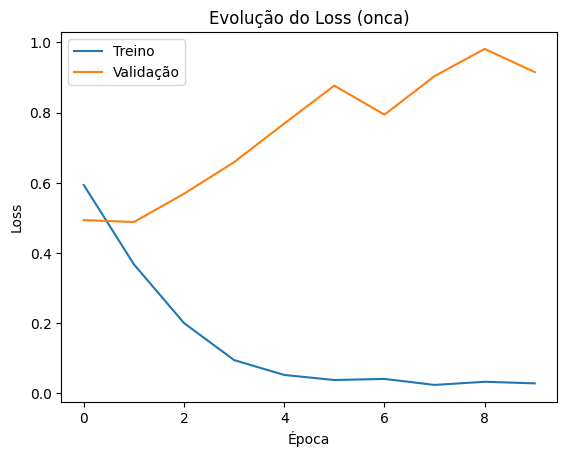

Modelo carregado com sucesso.


In [7]:
"""
train_bert.py
Treina o modelo BERT para uma das categorias.
Uso:
    python train_bert.py onca
    python train_bert.py caseiro
    python train_bert.py fakenews
"""
# Importa bibliotecas necessárias
import sys
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW # otimizador recomendado para Transformers
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

"""
#VSCODE: coloque esse código no vscode ao invés do que está abaixo.
# Verifica o argumento da categoria
if len(sys.argv) != 2:
    print("ATENÇÃO! Uso correto: python train_bert.py [onca|caseiro|fakenews]")
    sys.exit(1)
"""

# Define manualmente o argumento da categoria (simulando chamada via terminal)
sys.argv = ["train_bert.py", "onca"]
#sys.argv = ["train_bert.py", "caseiro"]
#sys.argv = ["train_bert.py", "fakenews"]

# Captura a categoria escolhida
categoria = sys.argv[1]
print(f"\nTreinando modelo para a categoria: {categoria.upper()}")

# Classe personalizada para preparar o dataset para o BERT
class NewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        # Lista de textos e rótulos
        self.texts = df["comment_text"].tolist()
        self.labels = df["label_id"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        # Retorna o tamanho do dataset
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokeniza o texto no formato esperado pelo BERT
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        # Retorna dicionário com input_ids, máscara de atenção e rótulo
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx])
        }

# Configurações do modelo
model_name = "neuralmind/bert-base-portuguese-cased"  # BERT em português
tokenizer = BertTokenizer.from_pretrained(model_name)

# Define número de classes (3 para onça/caseiro, 2 para fake news)
num_labels = 3 if categoria in ["onca", "caseiro"] else 2
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Usa GPU se disponível, senão CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Carrega datasets de treino e validação
train_df = pd.read_csv(f"train_{categoria}.csv")
val_df = pd.read_csv(f"val_{categoria}.csv")

# Cria DataLoaders para treino e validação
train_loader = DataLoader(NewsDataset(train_df, tokenizer), batch_size=8, shuffle=True)
val_loader = DataLoader(NewsDataset(val_df, tokenizer), batch_size=8)

# Define otimizador e número de épocas
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 10
train_losses, val_losses = [], []

# Loop de treinamento
for epoch in range(epochs):
    print(f"\nÉpoca {epoch + 1}/{epochs}")
    model.train()  # modo treino
    total_loss, total_val_loss = 0, 0
    preds, labels = [], []

    # Treino
    for batch in train_loader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}  # envia para GPU/CPU
        outputs = model(**batch)  # forward
        loss = outputs.loss
        loss.backward()  # backpropagation
        optimizer.step()  # atualização dos pesos
        total_loss += loss.item()

    # Validação
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()
            # Predições e rótulos para cálculo da acurácia
            preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            labels.extend(batch["labels"].cpu().numpy())

    # Calcula acurácia da validação
    val_acc = accuracy_score(labels, preds)
    print(f"Loss treino: {total_loss/len(train_loader):.4f} | Loss val: {total_val_loss/len(val_loader):.4f} | Acurácia val: {val_acc:.3f}")

    # Armazena perdas para plotar depois
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(total_val_loss / len(val_loader))

# Salva pesos do modelo treinado
torch.save(model.state_dict(), f"bert_{categoria}.pt")
print(f"\n Modelo salvo: bert_{categoria}.pt")

# Plota gráfico da evolução do loss
plt.plot(train_losses, label="Treino")
plt.plot(val_losses, label="Validação")
plt.legend()
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title(f"Evolução do Loss ({categoria})")
plt.savefig(f"loss_{categoria}.png")
plt.show()

print("Modelo carregado com sucesso.") # teste


In [8]:
"""
evaluate_bert.py
Avalia o modelo BERT para uma categoria específica.
Uso:
    python evaluate_bert.py onca
    python evaluate_bert.py caseiro
    python evaluate_bert.py fakenews
"""
# Importa bibliotecas necessárias
import sys
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

"""
#VSCODE: coloque esse código no vscode ao invés do que está abaixo.
# Argumento
if len(sys.argv) != 2:
    print("Uso correto: python evaluate_bert.py [onca|caseiro|fakenews]")
    sys.exit(1)

categoria = sys.argv[1]
print(f"\nAvaliando modelo para a categoria: {categoria.upper()}")
"""

#COLAB: coloque esse código no colab ao invés do que esta acima.
# Define manualmente a categoria que será avaliada
categoria = "onca"
#categoria = "caseiro"
#categoria = "fakenews"
print(f"\nAvaliando modelo para a categoria: {categoria.upper()}")

# Classe personalizada para preparar o dataset para o BERT
class NewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        # Extrai textos e rótulos do dataframe
        self.texts = df["comment_text"].tolist()
        self.labels = df["label_id"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        # Retorna o tamanho do dataset
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokeniza o texto no formato esperado pelo BERT
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        # Retorna dicionário com input_ids, máscara de atenção e rótulo
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx])
        }

# Configurações do modelo
model_name = "neuralmind/bert-base-portuguese-cased"  # BERT em português
tokenizer = BertTokenizer.from_pretrained(model_name)
# Número de classes depende da categoria (3 para onça/caseiro, 2 para fake news)
num_labels = 3 if categoria in ["onca", "caseiro"] else 2

# Carrega modelo pré-treinado e pesos salvos
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.load_state_dict(torch.load(f"bert_{categoria}.pt", map_location="cpu"))
model.eval()  # coloca em modo avaliação

# Carrega dados de teste
test_df = pd.read_csv(f"test_{categoria}.csv")
test_loader = DataLoader(NewsDataset(test_df, tokenizer), batch_size=8)

# Avaliação do modelo
preds, labels = [], []
with torch.no_grad():  # desativa gradientes (não há treino)
    for batch in test_loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        outputs = model(input_ids, attention_mask=attention_mask)
        # Obtém predições (classe com maior probabilidade)
        preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        # Armazena rótulos verdadeiros
        labels.extend(batch["labels"].cpu().numpy())

# Relatório de desempenho
print("\nRelatório de Classificação:")
if categoria in ["onca", "caseiro"]:
    names = ["Negativo", "Neutro", "Positivo"]
else:
    names = ["Não", "Sim"]

# Exibe métricas de precisão, recall e f1-score
print(classification_report(labels, preds, target_names=names))
print("Matriz de confusão:")
print(confusion_matrix(labels, preds))

# Mostra exemplos de erros de classificação
print("\nExemplos de erros:")
for i in range(len(test_df)):
    if preds[i] != labels[i]:
        print(f"Texto: {test_df.iloc[i]['comment_text']}")
        print(f"Verdadeiro: {names[labels[i]]} | Previsto: {names[preds[i]]}\n")




Avaliando modelo para a categoria: ONCA


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Relatório de Classificação:
              precision    recall  f1-score   support

    Negativo       0.54      0.56      0.55       108
      Neutro       0.88      0.88      0.88       513
    Positivo       0.57      0.48      0.52        54

    accuracy                           0.80       675
   macro avg       0.66      0.64      0.65       675
weighted avg       0.80      0.80      0.80       675

Matriz de confusão:
[[ 61  44   3]
 [ 42 454  17]
 [ 10  18  26]]

Exemplos de erros:
Texto: Não faltou experiência, faltou vigilância, e ele vacilou  teria é que rapar fogo nela.
Verdadeiro: Neutro | Previsto: Negativo

Texto: Fatalidade! Chega !<br>O negativo do acontecido é q confirmou uma negativa de preservação!<br>Onça deve ser protegida sim, domesticada não!
Verdadeiro: Positivo | Previsto: Negativo

Texto: A verdade é que a ganância do homem, cada vez mais avança em áreas de mata, para colocarem gado, plantarem soja , construírem pousadas e etc.   Precisamos repensar se não i